In [1]:
import os 
import numpy as np
import tensorflow as tf
import shutil
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image
import os

In [3]:
model = tf.keras.models.load_model('image_classification_model.h5')

In [4]:


diretorio = f'data/test/'

imagens = []
resposta = []

#percorre cada arquivo do diretorio
for root, dirs, files in os.walk(diretorio):
    for arquivo in files:
        img_path = os.path.join(root, arquivo)

        img = image.load_img(img_path, target_size=(128, 128))  # Substitua o tamanho alvo conforme necessário
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalização da imagem (se não foi feito durante o treinamento)
        imagens.append(img_array)
        resposta.append(root.split('/')[-1])

In [5]:
df = pd.DataFrame({'imagem':imagens, 'classe' : resposta})
df.head()

,imagem,classe
0,"[[[[0.5921569 0.57254905 0.47058824], [0.6117...",cloudy
1,"[[[[0.6392157 0.6745098 0.6431373], [0.6392157...",cloudy
2,"[[[[0.627451 0.63529414 0.57254905], [0.6274...",cloudy
3,"[[[[0.6 0.5803922 0.5411765], [0.6 ...",cloudy
4,"[[[[0.6392157 0.5647059 0.49019608], [0.6431...",cloudy


In [23]:
class_names = ['cloudy', 'desert', 'green_area', 'water']  # Lista das classes em ordem

predict_prob = []
df['predict'] = np.nan

for i in range(df.shape[0]):
    imagem = df['imagem'].iloc[i]
    
    predictions = model.predict(imagem)

    # # Obtenha a classe prevista
    class_index = np.argmax(predictions)
    predicted_class = class_names[class_index]

    df['predict'].iloc[i] = predicted_class
    predict_prob.append(predictions)
df['predict_prob'] = predict_prob


1/1 [==============================] - 0s 37ms/step


c:\Users\55119\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1/1 [==============================] - 0s 29ms/step


ValueError: Length of values (1) does not match length of index (1407)

In [26]:
pd.pivot_table(df,
               index = 'classe',
               columns = 'predict',
               values = 'imagem',
               aggfunc=len,
               margins = True)

predict,cloudy,desert,green_area,water,All
classe,,,,,
cloudy,331.0,39.0,3.0,2.0,375
desert,5.0,277.0,NaN,NaN,282
green_area,NaN,NaN,291.0,84.0,375
water,5.0,NaN,67.0,303.0,375
All,341.0,316.0,361.0,389.0,1407


In [27]:
acuracia  = (df[df['classe'] == df['predict']].shape[0]/ df.shape[0])*100
print(f'O modelo tem {round(acuracia, 2)}% para os dados de teste')

O modelo tem 85.43% para os dados de teste


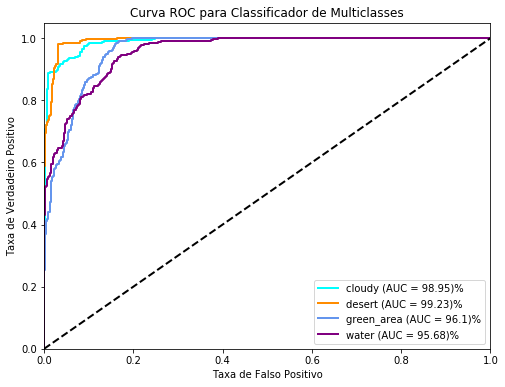

0.9749208954129785

In [61]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_roc_auc_multiclass(df_ ,y_true, y_score, classes):
    """
    Plota a curva ROC e calcula a AUC para um classificador de multiclasses usando a abordagem "one-vs-all".

    Parâmetros:
    - y_true: Rótulos verdadeiros (array 1D)
    - y_score: Pontuações do classificador para cada classe (array 2D)
    - n_classes: Número de classes

    Retorno:
    - Plota a curva ROC para cada classe e retorna a AUC média.
    """

    df = df_.copy()

    n_classes = len(classes)

    # Binariza os rótulos verdadeiros
    for c in classes:
        df[c] = np.where(df[y_true] == c, 1, 0)

    # Inicializa variáveis para armazenar as taxas de falso positivo e verdadeiro positivo
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Calcula a curva ROC e a AUC para cada classe
    for i in range(n_classes):
        fpr[class_names[i]], tpr[class_names[i]], _ = roc_curve(df[class_names[i]], df[y_score].apply(lambda x: x[0][i]))
        roc_auc[class_names[i]] = auc(fpr[class_names[i]], tpr[class_names[i]])

    # Calcula a média das AUCs de todas as classes
    auc_macro = np.mean(list(roc_auc.values()))

    # Plota a curva ROC para cada classe
    plt.figure(figsize=(8, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[class_names[i]], tpr[class_names[i]], color=color, lw=2, label=f'{class_names[i]} (AUC = {round(roc_auc[class_names[i]]*100, 2)})%')

    # Plota a linha diagonal (sem discriminação)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC para Classificador de Multiclasses')
    plt.legend(loc="lower right")
    plt.show()

    return auc_macro

class_names = ['cloudy', 'desert', 'green_area', 'water']
plot_roc_auc_multiclass(df, 'classe', 'predict_prob',class_names)

In [56]:

# Binariza os rótulos verdadeiros
for c in class_names:
    df[c] = np.where(df['classe'] == c, 1, 0)

# Inicializa variáveis para armazenar as taxas de falso positivo e verdadeiro positivo
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcula a curva ROC e a AUC para cada classe
for i in range(len(class_names)):
    fpr[class_names[i]], tpr[class_names[i]], _ = roc_curve(df[class_names[i]], df['predict_prob'].apply(lambda x: x[0][i]))
    roc_auc[class_names[i]] = auc(fpr[class_names[i]], tpr[class_names[i]])

In [55]:
df

,imagem,classe,predict_prob,predict,cloudy,desert,green_area,water
0,"[[[[0.5921569 0.57254905 0.47058824], [0.6117...",cloudy,"[[0.88805026, 0.1119488, 2.831411e-11, 8.97869...",cloudy,1,0,0,0
1,"[[[[0.6392157 0.6745098 0.6431373], [0.6392157...",cloudy,"[[0.9978509, 0.0019201464, 1.1790611e-08, 0.00...",cloudy,1,0,0,0
2,"[[[[0.627451 0.63529414 0.57254905], [0.6274...",cloudy,"[[0.98714185, 0.012792546, 1.0703146e-08, 6.56...",cloudy,1,0,0,0
3,"[[[[0.6 0.5803922 0.5411765], [0.6 ...",cloudy,"[[0.9651268, 0.03468552, 1.2025093e-07, 0.0001...",cloudy,1,0,0,0
4,"[[[[0.6392157 0.5647059 0.49019608], [0.6431...",cloudy,"[[0.0559402, 0.9440562, 6.051915e-08, 3.451833...",desert,1,0,0,0
...,...,...,...,...,...,...,...,...
1402,"[[[[0.14117648 0.23921569 0.31764707], [0.1411...",water,"[[0.005705144, 0.00045773183, 0.61586946, 0.37...",green_area,0,0,0,1
1403,"[[[[0.09019608 0.17254902 0.2784314 ], [0.0901...",water,"[[0.0005417298, 5.2347554e-05, 0.019191196, 0....",water,0,0,0,1
1404,"[[[[0.2627451 0.40784314 0.4392157 ], [0.2627...",water,"[[0.0019431085, 5.3235253e-06, 0.011526411, 0....",water,0,0,0,1
1405,"[[[[0.18039216 0.29803923 0.34117648], [0.1803...",water,"[[0.0049582575, 0.000118956705, 0.30648825, 0....",water,0,0,0,1


In [49]:
df['classe']

0       cloudy
1       cloudy
2       cloudy
3       cloudy
4       cloudy
         ...  
1402     water
1403     water
1404     water
1405     water
1406     water
Name: classe, Length: 1407, dtype: object

In [39]:
df['predict_prob'].apply(lambda x: x[0][i])

IndexError: index 1406 is out of bounds for axis 0 with size 4